<a href="https://colab.research.google.com/github/kylechanpols/sid/blob/main/training_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the U-Net to measure local economic development

Kyle Chan (UNC-Chapel Hill, kylechan@unc.edu)
(with some code adapted from Yann Le Guilly)

Welcome to the demo page for my project to measure local economic development using satellite imagery! In this Google Colab workbook I will explain every step taken to construct the local development index using satellite images through the U-Net architecture. As of 9/4, the model is trained on around 3400 images. When tested on a test set of around 430 images, it has achieved a 91% test set accuracy and a mean intersection-over-union score of around 90.5%.

A more technical notebook explaining every function in the helper scripts is available [here](https://colab.research.google.com/drive/1kX184eOiWFCr9wCH6tccXIN2AEHZ1bsV?usp=sharing).


## Motivation

In the literature of subnational politics, we don't really have very micro-level measure of important qualities such as political decentralization, economic development, etc at the local level. This is very unfortunate because our theorization tends to happen on a very local scale, but then the data we have are still very aggregated.

## Measuring Local Economic Development

On the measurement of local economic development we run into the same issue. Economists have used two approaches two get around this issue: One is with luminosity score, which utilizes a satellite to capture images of a local area. The images are taken at night, which they theorize that more developed areas are more likely to have more nightlights than underdeveloped areas. This approach has so far been the state-of-the-art for many years in that literature. However, it does have several limitations:

- Clouds can obscure the luminosity on the ground level. Some corrections can be made by taking multiple images at different times and exclude cloudy ones. But if the location is prone to clouds often then the adjustment may not work.
- Nightlights may not portray an accurate picture of the ground truth due to policy constraints, e.g. some Nordic countries turn off street lights at night to protect birds.

Another approach is to abstract the GDP level using an assortiment of weighting methods. This approach is also known as the "Gross Cell Product" (GCP) measure. However, it still has its fair share of limitations:

- The GCP measure is computed on other various measures that might have severe inaccuracy, particularly when measuring developing countries where the data quality can be sometimes questionable.
- The GCP is also subject to problems of missing data, particularly when used to measure developing countries.

Thus an alternative approach is required if we were to go even lower to capture local economic development.

## Measuring Local Economic Development with Satellite Images

We can measure local economic development is by using satellite images. Consider the case that we need to measure the level of local economic development of a city. We can look from above and count how many buildings are there in a city. Most people would agree that cities are more developed than rural areas, and thus all we need is to reframe the question and think about how much buildings/roads are there in an image vs. what portion of the image is a forest or other types of natural terrain untouched by human economic activity.

Consider these two images:

<img src="https://drive.google.com/uc?id=1f03r6xFe4S27-oIjdUIzcZlowWayuGFs" alt="Rural" width="256"/>
<img src="https://drive.google.com/uc?id=12NYztvcf0-WqEKkDSuhys19CF4BYJo7d" alt="Urban" width="256"/>

The left hand side is a snapshot of a countryside. When compared to the image to the right, a urban suburb, we can see that they contain drastically different information:
- Overall tone: The rural image has a lot more forest and farmland than the urban image. In other words, this means that the overall Green channel of the image to the left will have higher values than the urban image.
- Presence of White/Gray Classes: The rural image has fewer buildings than the urban image. Buildings usually have gray or bright color roofs. In the urban image, that is much more common than the rural image.
- Density of items: Items in the rural image are less densely packed than the urban image. In the urban image, the buildings are all closely stacked next to each oither. In other words, there are more lines separating buildings in the urban image. Shapes of buildings in the urban image also tend to be more rectangular than the fuzzly shaped farmlands and forests in the rural image.

These are important **features** that the deep learning model can learn from. With these features the model should be able to differentiate a rural, less developed image from an urban, more developed image.

# The Model

## Convolutional Neural Network

For images, it is very common to use convolutional neural networks (CNN/ ConvNets). To be brief, ConvNets parse an image through an operation called "convolution", and learn model weights after each convolution.

A **convolution** can be think of a way to abstract or morph an image such that the model can focus on particular parts of an image. These instructions on where to focus in an image are called **filters**. Filters can be of any size, and contain values that emphasize which part of an image gets more weight, and which part gets less. For example, consider the following (3,3) filter:

<table>
<thead>
  <tr>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">-1</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">-1</td>
  </tr>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">-1</td>
  </tr>
</tbody>
</table>

Let 1 denote a bright pixel and -1 denote a dark pixel. Then what the filter means is that we are reading in a light edge to the right, where the third column contains a column vector of darker pixels.

A **convolution** uses a sliding window algorithm to go through each part of the subnmatrix within an image, compute an element-wise product between the submatrix and the filter, and then sum the contents of the matrix into a scalar in the output. 

The **padding** of a convolution denotes how far ahead should the sliding window algorithm "look ahead" for submatrices in the image. By default, most deep learning frameworks would have padding=1, which means that the sliding window will shift right by one column (or shift down by one row after the columns have been exhausted) and compute convolutions from those submatrices.

## Example:
Consider the following $3*3*1$ (grayscale) image:

<table>
<thead>
  <tr>
    <th class="tg-0lax">3</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax">5</td>
    <td class="tg-0lax">8</td>
  </tr>
  <tr>
    <td class="tg-0lax">2</td>
    <td class="tg-0lax">7</td>
    <td class="tg-0lax">2<br></td>
  </tr>
</tbody>
</table>

Say we apply a $3*3$ filter once:

<table>
<thead>
  <tr>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">-1</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">-1</td>
  </tr>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">-1</td>
  </tr>
</tbody>
</table>

The outcome of this covolution is -5.

### Explanation

We compute an element-wise product by multiplying cell to cell from the image to the filter. Therefore, the only submatrix in this convolution is:

<table>
<thead>
  <tr>
    <th class="tg-0lax">3</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">-1</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">-8</td>
  </tr>
  <tr>
    <td class="tg-0lax">2</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">-2</td>
  </tr>
</tbody>
</table>

We compute the sum of all elements in this submatrix: 3+0-1+1+0-8+2+0-2 = -5.

For a more complicated example, consider the following $4*4*1$ grayscale image:

<table>
<thead>
  <tr>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">2</th>
    <th class="tg-0lax">3</th>
    <th class="tg-0lax">4</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">4</td>
    <td class="tg-0lax">3</td>
    <td class="tg-0lax">2</td>
    <td class="tg-0lax">1</td>
  </tr>
  <tr>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
  </tr>
  <tr>
    <td class="tg-0lax">5</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">5</td>
  </tr>
</tbody>
</table>

Applied to the same $3*3$ filter above once, with padding=1. You should get a small $2*2$ output image:

<table>
<thead>
  <tr>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">0</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">9</td>
    <td class="tg-0lax">-3</td>
  </tr>
</tbody>
</table>

### Explanation:
Use the sliding window algorithm to find 4 submatrices: they should be the following:
<table style="float: left; width:25%">
<thead>
  <tr>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">2</th>
    <th class="tg-0lax">3</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">4</td>
    <td class="tg-0lax">3</td>
    <td class="tg-0lax">2</td>
  </tr>
  <tr>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
  </tr>
</tbody>
</table>
<table style="float: left; width:25%">
<thead>
  <tr>
    <th class="tg-0lax">2</th>
    <th class="tg-0lax">3</th>
    <th class="tg-0lax">4</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">3</td>
    <td class="tg-0lax">2</td>
    <td class="tg-0lax">1</td>
  </tr>
  <tr>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
  </tr>
</tbody>
</table>
<table style="float: left; width:25%">
<thead>
  <tr>
    <th class="tg-0lax">4</th>
    <th class="tg-0lax">3</th>
    <th class="tg-0lax">2</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
  </tr>
  <tr>
    <td class="tg-0lax">5</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
  </tr>
</tbody>
</table>
<table style="float: left; width:25%">
<thead>
  <tr>
    <th class="tg-0lax">3</th>
    <th class="tg-0lax">2</th>
    <th class="tg-0lax">1</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
  </tr>
  <tr>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">5</td>
  </tr>
</tbody>
</table>

Compute the element-wise product for each of the submatrices with the filter, then sum:
$$1+0-3+4+0-2+0+0+0 = 0$$
$$2+0-4+3+0-1+0+0+0 = 0$$
$$4+0-2+0+0+0+5+0+0 = 9$$
$$3+0-1+0+0+0+0+0-5 = -3$$

And thus the output is $2*2$:
<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">0</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">9</td>
    <td class="tg-0lax">-3</td>
  </tr>
</tbody>
</table>

In ConvNets, there will be convolution steps to abstract or morph the image as such. There are model weights that are associated with each element in the convolution output. Depending on the architecture, there could be an activation function following the convolution.




## Semantic Segmentation

The way that we can appraoch this machine learning problem is by the technique of semantic segmentation. Semantic segmentation means that we are assiging classes to each pixel of the image. The model then learns and predicts at the pixel level of the image. The segmentation task of finding different areas in an image is known as **semantic segmentation**. The segmentation task can also be applied to object detection, and that variant is called **instance segmentation**.

An image where each pixel is differentiated into different classes are called a **segmentation mask**. For example, consider the urban image example from before. We can highlight all buildings and roads and label them as "1"s, and everything else as "0"s. The resulting mask (by scaling everything by 255 such that it is a proper grayscale image) would look like the one to the right:

<img src="https://drive.google.com/uc?id=12NYztvcf0-WqEKkDSuhys19CF4BYJo7d" alt="Urban" width="256"/>
<img src="https://drive.google.com/uc?id=1VMBxH81uwqydFm4BS1yOdftRTwy00E4R" alt="Rural" width="256"/>

The task for the model is to learn from features in the source image to the left and find out how the features are related to the outcome in the segmentation mask.


## The U-Net architecture

In this paper I used the U-Net Architecture (Ronneberger, Fischer & Brox, 2015).The U-Net architecture has an equal number of encoding layers and decoding layers (and thus the architecture looks like a big U). The architecture makes extensive use of skip connection (i.e. caching output from the encoding layers and stack them ontop of the decoding layers).

The main advantage of a model that makes extensive use of skip connections is the runtime. With skip connection we skipped the calculations of many of the convolutions computed in the encoding stage. In addition, skip connection has another advantage of avoiding the problem of vanishing gradients (i.e. gradients for features become so small that it's essentially 0).

When visualized, the U-Net architecture looks like the following:

![](https://drive.google.com/uc?id=1lrkTBa7mpvNoDxLavD45W3drDGDaMSIj)

## Loss Function

The loss function used here is the binary cross-entrophy:
$$L(\theta) = \frac{1}{n}\sum^n_{i=1} \ [y_i log(p_i)+(1-y_i)log(1-p_i)]$$

where $p_i \in (0,1)$ denotes the probability of $y_i$ is exactly of class 1. $y_i$ is the class label, where 0 denotes a non-building pixel and 1 denotes a building pixel.

## The Adam Optimizer

The Adaptive Moment Estimation (Adam) optimizer is used for this problem. Adam is preferred over other optimizers because it has the best performance out of all existing optimizers in the market. It combines the idea of the exponentially weighted average to incorporate the notion of momentum, along with Root Mean Square Propagation (RMSProp) - so it's a hybrid of two optimization techniques in the market. In the following test we see that the training cost is the lowest with Adam:

![](https://machinelearningmastery.com/wp-content/uploads/2017/05/Comparison-of-Adam-to-Other-Optimization-Algorithms-Training-a-Multilayer-Perceptron.png)

It is also a highly versatile optimizer, with up to 4 hyperparameters available for tuning:
- $\alpha$ - learning rate
- $\beta_1$ - can be understood as the rate controlling the velocity for the gradients
- $\beta_2$ - can be understood as the rate controlling the velocity for the squared gradients (part of the RMSProp)
- $\epsilon$ - adjustment to the RMSProp correction

### Learning Rate Decay

In this model I have also incorporate learning rate decay with rate = 0.9. Recall that learning rate decay means that the learning rate $\alpha$:
$$\alpha = \frac{1}{1+ decayRate*epochNr.}$$

Depending on how large `decayRate` is, we can control how quickly or slowly does the model adapt to a solution. A large `decayRate` implies that we will spread out the learning rate a bit more, thus slowing down learning in the initial epochs.

## Metrics

Two metrics are used in this problem:
- Accuracy
- Mean Intersection-over-union (IoU)

### Accuracy

As the name suggests, accuracy shows how many percentages of the pixels are correctly identified by the model when evaluated against some unseen examples. 

### Mean Intersection-over-union (IoU)

This is a more suitable metric for the semantic segmentation task. The IoU score for each class is defined as follows:

$$\frac{TruePositive}{TruePositive + FalsePositive + FalseNegative}$$

and the mean IoU is the average of this score across all classes. The Mean IoU is more suitable because it considers also the false negatives.

## The Dataset

The Dataset is a collection of satellite images for 22 cities across Western Europe and the US. The entire dataset contains 4314 images, collected from Google Satellite Images. Google has a fixed interval of updates to satellite images between 1 to 3 years, so the images in the dataset are all captured from the 2017-2020 period. This means that the nature of the dataset is cross-sectional.

A 8:1:1 train/dev/test split is conducted on the dataset. This results in a training set of 3450 images, dev set of 433 images and 431 images. Validation and fine-tuning of hyperparameters are conducted on the dev set, whereas the test set is used to compute the test accuracy and the mean IoU score. As I extend the dataset to cover more cities outside of the Western hemisphere, the training set could take on a higher weight, to something akin to 9:0.5:0.5.



# Model Training

Below presents the code for model training. To save space, the python code are all stored in separate `.py` scripts and this Jupyter Notebook sources code from them.


## Software Requirements

If you wish to run the script locally, please ensure that your local machine fulfills the following software requirements:

- TensorFlow version >=2.6
- Python version >=3.7

## Accessing the Dataset and Scripts

If you wish to run the code on your own Colab, please follow these instructions.

1. Open up this [shared folder link](https://drive.google.com/drive/folders/1m38V-wL2gPonnoeZtQYD3jBfLf0dbBth?usp=sharing) on Google Drive.

2. You will now clone the dataset and scripts into your own Google Drive. Please make sure your Google Drive has free space of at least 3GB to save all images and the scripts. Once in the link, go back to the "Shared With Me" Folder:

<img src="https://drive.google.com/uc?id=1lLtDN8bs6qwMapaPLuoOnli4CC128_Tq" alt="Urban" width="512"/>

3. In the "Shared with Me" folder, select the "Metropolitan Area Dataset" Folder. Right click to get the options menu. Click "Add Shortcut to Drive":

<img src="https://drive.google.com/uc?id=1ePZs9Wkeaq8o2iZStOl-r5TKBTRTUNLz" alt="Urban" width="512"/>

4. Click "My Drive" (or the desired folder), and then click "Add Shortcut".

<img src="https://drive.google.com/uc?id=1TO38lECSiAPRLKTk0mBXpFH-uZU3AbQD" alt="Urban" width="512"/>

5. The Dataset is now cloned to your own Google Drive. You can now mount your own Google Drive, access the cloned dataset and scripts and run them on your Google Colab!


## Getting Ready to train the model

We will begin by mounting my Google Drive, importing the TensorFlow framework, and a few base Python packages:

(If you saved the folder somewhere inside My Drive, note that you need change the `home` variable in the following Code Chunk to the corresponding folder. Let's Say the contents of `Metropolitan Area Dataset` live in `My Drive/Research/Datasets/`, then you need to change `home` variable to: `"/content/gdrive/My Drive/Research/Datasets/Metropolitan Area Dataset"`)

In [2]:
from google.colab import drive # for Google Drive Mounting
home = "/content/gdrive/My Drive/Metropolitan Area Dataset"
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
import datetime
import os
import re

# Clear any logs from previous runs
#rm -rf ./logs/

The following script summarizes the training environment (Nr. CPUs and Nr. GPUs),  sizes of the train/dev/test sets, and a random sample of the image and its segmentation mask.

Note that I have sized all images to $128*128$ to save computation cost. After all, parsing one $128*128*3 = 49152$ digits is already quite hefty on the machine!

Randomly initialized weights would be used to predict the segmentation mask. The intialized weights should be a very poor prediction of the segmentation mask.

In [3]:
script_path = "/content/gdrive/My Drive/Metropolitan Area Dataset"

exec(open(os.path.join(script_path + "/model_compile.py")).read())

print("Nr. Epochs",EPOCHS,sep=" ")
print("Nr. Steps per Epoch",STEPS_PER_EPOCH,sep=" ")

Tensorflow ver. 2.6.0
The Training Dataset contains 3450 images.
The Validation Dataset contains 433 images.
The Testing Dataset contains 431 images.
Nr. Epochs 30
Nr. Steps per Epoch 107


We will now initialize some weights, and generate predictions to see if the model is producing output in the expected dimensions:

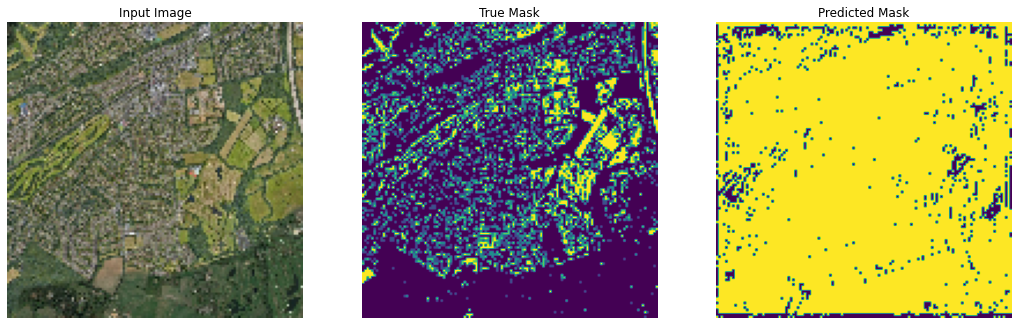

In [ ]:
show_predictions()

The intialized weights are all over the place, and thus the prediction is obviously all off. All is good. Just for a sanity check, let's get the summary of the model:

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Just like the U-Net architecture states, in the encoding stage the convolutions are applied increasingly more and more, so you see that the number of channels increase while the dimension of the input image shrinks. After each series of convolutions, a skip connection is made with `Concatenate()`. Later, once we are in the decoding stage, we perform convolutions such that the number of channels decrease and slowly make it back to the original image dimensions. In each decoding stage we will use the cached output from the encoding stage.

The model has a total of 31 million parameters to be learned! This is why fitting this model can take a long time. Accelerating the computation with a graphics card is almost necessary for this task. Using the Nvidia GTX 1060 on my local machine, I was able to pass through one epoch of 107 images in around a minute.

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# On GPU
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'],
                          callbacks = [tensorboard_callback])

%tensorboard --logdir logs/fit

Epoch 1/30
107/107 [==============================] - 91s 702ms/step - loss: 0.2845 - accuracy: 0.8408 - updated_mean_io_u: 0.4616 - val_loss: 0.1310 - val_accuracy: 0.9522 - val_updated_mean_io_u: 0.4858
Epoch 2/30
107/107 [==============================] - 72s 675ms/step - loss: 0.1818 - accuracy: 0.8399 - updated_mean_io_u: 0.4614 - val_loss: 0.0759 - val_accuracy: 0.9522 - val_updated_mean_io_u: 0.4858
Epoch 3/30
107/107 [==============================] - 73s 686ms/step - loss: 0.1508 - accuracy: 0.8416 - updated_mean_io_u: 0.4618 - val_loss: 0.0616 - val_accuracy: 0.9522 - val_updated_mean_io_u: 0.4858
Epoch 4/30
107/107 [==============================] - 74s 694ms/step - loss: 0.1314 - accuracy: 0.8557 - updated_mean_io_u: 0.5642 - val_loss: 0.0700 - val_accuracy: 0.9728 - val_updated_mean_io_u: 0.8331
Epoch 5/30
107/107 [==============================] - 72s 675ms/step - loss: 0.1179 - accuracy: 0.8807 - updated_mean_io_u: 0.7379 - val_loss: 0.1101 - val_accuracy: 0.9590 - val_u

Reusing TensorBoard on port 6006 (pid 39964), started 1 day, 7:49:38 ago. (Use '!kill 39964' to kill it.)

## Loading pre-trained model weights

To save the training time, I pre-fitted the weights on my local machine. There are two sets of weights:

- Day 2 - Final weights trained with $\alpha$ fixed at .0001.
- Day 2 - LRD trained with $\alpha$ subject to learning rate decay, rate=0.9 for the first 10000 iterations.

Let's set the `checkpoint_path` to point to the folder containing the pre-trained model weights.

In [ ]:
checkpoint_path = dataset_path+"/weights/"+"cp-day2-lrd.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

## Check Test Accuracy

When tested against the test set, the accuracy and Mean IoU scores are computed. The model with learning rate decay has the best performance. With test set accuracy  at 90.99% and the updated mean IoU score at 90.47%.


In [ ]:
model.load_weights(checkpoint_dir+"/cp-day2.ckpt")

loss, acc, miou = model.evaluate(dataset['test'], verbose=2)
print("Day 2 Model, accuracy: {:5.2f}%".format(100 * acc), "Mean IoU: {:5.2f}%".format(100 * miou), sep=" ")

model.load_weights(checkpoint_dir+"/cp-day2-lrd.ckpt")

loss, acc, miou = model.evaluate(dataset['test'], verbose=2)
print("Day 2 Model (+Learning Rate Decay), accuracy: {:5.2f}%".format(100 * acc), "Mean IoU: {:5.2f}%".format(100 * miou), sep=" ")


14/14 - 205s - loss: 0.0331 - accuracy: 0.9076 - updated_mean_io_u_3: 0.9038
Day 2 Model, accuracy: 90.76% Mean IoU: 90.38%
14/14 - 203s - loss: 0.7468 - accuracy: 0.1412 - updated_mean_io_u_3: 0.0799
Day 2 Model (+Learning Rate Decay), accuracy: 14.12% Mean IoU:  7.99%


## Example Prediction

We can take a test set example and visualize the model predictions:

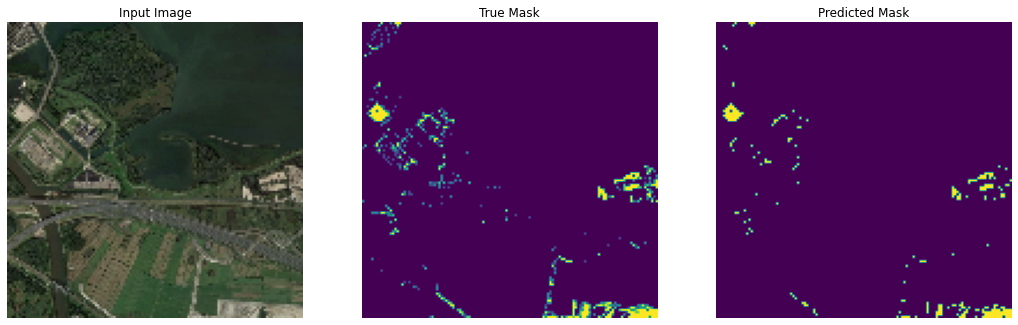

In [ ]:
model.load_weights(checkpoint_dir+"/cp-day2-lrd.ckpt")
draw = int(np.random.randint(low=0, high=BATCH_SIZE-1, size=1)) #randomly draw a number between 0-32

show_predictions(dataset=dataset['test'],num=1, num_in_batch = draw)

# Constructing the Index

The index for a particular area can be conducted by parsing all satellite images of a city through the model. The predictions for each image will then be a 128*128 float point array (due to the use of the softmax activation), where a pixel of 0.0 means that the pixel is not a building (completely black), and a 1.0 means that the pixel is a building with 100% probability.

If we sum across all images $g$: $\sum^g_{i=1}p_i$, this is a rough measure of the total level development of a city since it is a sum of all building pixels across all images.

However, this index must be weighted because the geographical size of each city is different. In some very large cities like Beijing or Moscow this measure is likely to be very large due to the sheer size of images parsed through the model.

To acquire a sense of the **per capita** development, this measure is weighted by the population of a city.

To get a sense of how unequal/ spread out is the development, we can either compute a correlation of variation (CV) or a gini coefficient. For the correlation of variation weighted by population, this is simply:

$$CV_{weighted} = 100*(\frac{SD}{Mean})*\frac{1}{Population}$$

This essentially means the per capita percentage of deviation of the index from its mean. Note that the mean is calculated at the image level. The number of images is dependent on the size of the city. But then we weight that again with the population, so we essentially have controlled for both city size and population size.

The gini coefficient can be defined as the following:
$$G = \frac{\sum^n_{i=1}\sum^n_{j=1}|x_i - x_j|}{2n^2\bar{x}}$$

This alternative definition takes advantage of the fact that the Gini coefficient is half of the relative mean absolute difference, a mathematically equivalent definition of the Lorenz curve. 

Note that the gini coefficient can only be computed at the image level. Because our measurement of "wealth" is at the image level, any method to compute the Gini Coefficient would always return a measure of inequality at the image level, not the population level. Therefore, the Gini Coefficient is computed in the dataset but not used in the main analysis.

The functions to compute the index is provided below:

In [ ]:
import pandas as pd #required for manipulation of the data as a dataset.

def gini(x: pd.Series) -> float:
    '''
    A **bruteforce** function to compute the gini coefficient.
    It computes the MAD of a distribution, and then reweights it with the relative MAD.

    Input: x: pd.Series - a pandas series representing a distribution.
    
    Output: g-> float : A float point value between -1 and 1 representing the degree of income inequality.
    -1 means absolutely no inequality and 1 means full inequality.

    Time Complexity: O(n**2)
    Space Complexity: O(n**2)

    Do NOT use for very large samples, e.g. n>10000.
    '''
    x = x.to_numpy(dtype=np.float32)

    x = x[np.logical_not(np.isnan(x))]
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

def makeDataset(val: pd.Series) -> pd.DataFrame:
    '''
    Description: Make a dataset from a list of named lists.

    Input: val: pd.Series
      pd.Series of predictions for a city, with the name of the series set to the name of that city.

    Output: pd.DataFrame
      A pd.DataFrame containing all predictions for a city as columns.
    '''
    df = {}
    for city,value in zip(ref,val):
        df['city'] = val
    return df

def acquireValues(path: str, normalized: bool) -> pd.Series:
    '''
    Description: a Function to translate satellite images from a folder to a measure of development.

    Inputs:
    - path (str) : The path to the folder containing .jpg satellite images.
    - normalized (bool): Should the program return normalized predictions or unnormalized image predictions?
      Normalization is defined as the coercion of pixels from scale 0 - 255 (RGB) to 0-1.
      Note that if normalized, then the images cannot be displayed properly by keras.utils.array_to_img().

    Outputs:
    - A pd.Series containing the sum of bright pixels in an image.
    - pd.Series.name - Contains the name of the folder (assumed to be name of city)
    '''
    ### the following code is for windows where using os.path.join would result in a unique identifier \\
    # for one path
    #city = re.search(r'\\([a-zA-Z]+$)',path)
    #city = city.group(1) #Acquire Name of city via Regex

    #for linux/mac, use this:
    city = os.path.basename(os.path.normpath(path)) #normpath gives us the "normalized" path by removing anything in between folders. #basename gives the current folder name.

    print("|","Processing:",city, sep=" ")

    TESTSET_SIZE = len(glob(path+ "/*.jpg"))
    print("|","City:",city,"contains",TESTSET_SIZE,"images", sep=" ")

    #correcting path
    path = tf.strings.regex_replace(path, "\\\\", "/")

    data_for_pred = tf.data.Dataset.list_files(path+"/*.jpg", seed=SEED, shuffle=False)
    data_for_pred = data_for_pred.map(parse_image_pred)
    data_for_pred = data_for_pred.batch(BATCH_SIZE)
    data_for_pred = data_for_pred.prefetch(buffer_size=AUTOTUNE)

    print("|--->","City",city,"has been processed by tf.data.Dataset.", sep =" ")

    preds = model.predict(data_for_pred)

    print("|--->","Predictions for",city,"acquired", sep=" ")

    if normalized == True:
        preds = tf.reshape(preds[:,:,:,1], (TESTSET_SIZE,IMG_SIZE, IMG_SIZE))
    else:
        preds = tf.reshape(preds[:,:,:,1]*255.0, (TESTSET_SIZE,IMG_SIZE, IMG_SIZE))

    preds = tf.math.reduce_sum(preds, axis=[1,2])

    out = pd.Series(list(preds), dtype=np.float32, name=city)

    print("|--->","Predictions for",city,"restructured to pd.Series.", sep=" ")

    return out

## Setup

Let's specify the location of the prediction dataset. This script would take each city as its own test set, parse all images for each city and generate predictions:

In [ ]:
pred_dataset = "/preds"
#reload the data loader for updated functions
exec(open(os.path.join(script_path + "/data_loader.py")).read())

In [ ]:
cities = [] #initialize a list of folders containing images for each city.

for root,dirs,files in os.walk(dataset_path + pred_dataset):
    for x in dirs:
        if(re.match(r'[a-zA-Z]',x)):
            cities.append(dataset_path + os.path.join(pred_dataset, x)) #using os.walk to find all folders

print(cities)

data = [acquireValues(x,True) for x in cities] #With a list comprehension, acquire a 2d array of predictions.
# The 2d array will show all the predictions for each city (in columns)

ds = pd.DataFrame(data=data) #convert  to data frame.
ds = ds.T # transpose the output.

['/content/gdrive/My Drive/Metropolitan Area Dataset/preds/Barcelona', '/content/gdrive/My Drive/Metropolitan Area Dataset/preds/Osaka', '/content/gdrive/My Drive/Metropolitan Area Dataset/preds/DC']
| Processing: Barcelona
| City: Barcelona contains 20 images
|---> City Barcelona has been processed by tf.data.Dataset.
|---> Predictions for Barcelona acquired
|---> Predictions for Barcelona restructured to pd.Series.
| Processing: Osaka
| City: Osaka contains 20 images
|---> City Osaka has been processed by tf.data.Dataset.
|---> Predictions for Osaka acquired
|---> Predictions for Osaka restructured to pd.Series.
| Processing: DC
| City: DC contains 36 images
|---> City DC has been processed by tf.data.Dataset.
|---> Predictions for DC acquired
|---> Predictions for DC restructured to pd.Series.


In [ ]:
sums = ds.sum(axis=0) #get the sum
means = ds.mean(axis=0) #get the mean
sds = ds.std(axis=0) #get the stddev

ginis = [gini(ds.iloc[:,x]) for x in range(len(ds.columns))] #get gini
ginis = pd.Series(ginis, name="Gini Coefficient")
ginis.index = means.index

ds_stats = pd.DataFrame({"sum":sums, "mean":means, "sd":sds, "gini":ginis}) #put into a ds

ds_stats.head(3)

#ds_stats.to_csv(script_path+"/metro_img_stats.csv") #save to csv. Population data has to be merged from another dataset using SQL join. That part is done in R.

,sum,mean,sd,gini
Barcelona,54721.226562,2736.061279,1935.760986,0.395616
Osaka,55077.734375,2753.886719,414.284790,0.077764
DC,16147.420898,448.539459,288.237701,0.343546


# Voilà!

This concludes the walkthrough of the data pipeline, from image preprocessing to index construction for this project. If you have any questions, please do not hesitate to contact me at my work email: kylechan@unc.edu.
